In [2]:
import trenchripper.trenchripper as tr

import omnipose
import tifffile
import dask
import h5py
import os

import skimage as sk
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.delayed as delayed

from parse import compile
from nd2reader import ND2Reader
from distributed.client import futures_of
from time import sleep
from cellpose_omni import models, core
from omnipose.utils import normalize99

from matplotlib import pyplot as plt

In [3]:
# addition of active memory manager
dask.config.set({'distributed.scheduler.active-memory-manager.start': True});
dask.config.set({'distributed.scheduler.worker-ttl': "5m"});
dask.config.set({'distributed.scheduler.allowed-failures': 100});

dask_wd = "/home/de64/scratch/de64/dask"

### Functions For Notebook

In [ ]:
def nd2_to_tiff(nd2file,fov_metadata_chunk,channels,tiff_metadata):
    #### start reading nd2 files
    with ND2Reader(nd2file) as nd2_input:
        for i,channel in enumerate(channels):
            for fov in fov_metadata_chunk.index.get_level_values(0).unique():
                for j in fov_metadata_chunk.index.get_level_values(1).unique():
                    fov_row = fov_metadata_chunk.loc[fov,j]
                    output_filename = fov_row[channel + " File Names"]
                    output_filename_path = tiff_output_path + "/" + output_filename
                    fovnum = fov_row["old fov"]
                    nd2_image = nd2_input.get_frame_2D(c=i, t=j, v=fovnum)
                    nd2_image = np.array(nd2_image)
                    tifffile.imwrite(output_filename_path,data=nd2_image,dtype="uint16",\
                                    extratags=tiff_metadata)
    return 1

def segment_omnipose(headpath,img_idx,seg_channel,min_size=500,border_buffer=4):
    imgpath = headpath + "/hdf5/hdf5_" + str(img_idx) + ".hdf5"
    segpath = headpath + "/phasesegmentation/segmentation_" + str(img_idx) + ".hdf5"
    with h5py.File(imgpath,"r") as infile:
        img_data = infile[seg_channel][:]

    try:
        img_data = normalize99(img_data)
        use_GPU = core.use_gpu()
        model_name = 'bact_phase_omni'
        model = models.CellposeModel(gpu=use_GPU, model_type=model_name)
        omni_masks, _, _ = model.eval(img_data,channels=[0,0],rescale=None,mask_threshold=-1,
                transparency=True,flow_threshold=0,
                niter=None,omni=True,cluster=True,resample=True,
                verbose=False,affinity_seg=0,tile=True,
                augment=False)

        unlabeled_composite_mask = omni_masks>0
        unlabeled_composite_mask = ~sk.morphology.binary_closing(~unlabeled_composite_mask)
        omni_masks[~unlabeled_composite_mask] = 0
        omni_masks = sk.morphology.remove_small_objects(omni_masks,min_size=min_size)
        omni_masks = sk.segmentation.clear_border(omni_masks,buffer_size=border_buffer)
        omni_masks,_,_ = sk.segmentation.relabel_sequential(omni_masks)
        
        omni_masks = omni_masks[np.newaxis,np.newaxis,:,:] #compatability with the mother machine code (k,t,y,x)
    except:
        omni_masks = np.zeros((1,1,img_data.shape[1],img_data.shape[2]),dtype="uint8")
        
    with h5py.File(segpath,"w") as outfile:
        outfile["data"] = omni_masks
    return 1

def segment_nucleoids(file_idx,headpath,cellsegfolder,nucleoidsegfolder,seg_channel,cell_otsu_scaling,\
                      min_size=400,border_buffer=4):
    with h5py.File(headpath + '/hdf5/hdf5_' + str(file_idx) + '.hdf5',"r") as infile:
        img_data = infile[seg_channel][:]
    with h5py.File(headpath + "/" + cellsegfolder + "/segmentation_" + str(file_idx) + ".hdf5","r") as infile:
        seg_data = infile["data"][:]

    img_arr = img_data[0]
    seg_arr = seg_data[0,0]

    composite_mask_list = []
    nucleoid_idx = 0
    if np.max(seg_arr)>0:
        for cell_i in range(1,np.max(seg_arr)+1):
            cell_seg_mask = (seg_arr==cell_i)
            cell_otsu_thr = sk.filters.threshold_otsu(img_arr[cell_seg_mask])*cell_otsu_scaling
            composite_mask = cell_seg_mask&(img_arr>cell_otsu_thr)

            composite_mask = sk.morphology.label(composite_mask).astype("uint8")
            nucleoid_idx_increment = np.max(composite_mask)
            composite_mask[composite_mask>0] = composite_mask[composite_mask>0]+nucleoid_idx
            nucleoid_idx += nucleoid_idx_increment
            composite_mask_list.append(composite_mask)
        composite_mask = np.sum(np.stack(composite_mask_list,dtype="uint8"),axis=0,dtype="uint8")
        ##morphological operations
        unlabeled_composite_mask = composite_mask>0
        unlabeled_composite_mask = ~sk.morphology.binary_closing(~unlabeled_composite_mask)
        composite_mask[~unlabeled_composite_mask] = 0
        composite_mask = sk.morphology.remove_small_objects(composite_mask,min_size=min_size)
        composite_mask = sk.segmentation.clear_border(composite_mask,buffer_size=border_buffer)
        composite_mask,_,_ = sk.segmentation.relabel_sequential(composite_mask)

        composite_mask = composite_mask[np.newaxis,np.newaxis,:,:]
        
    else:
        composite_mask = np.zeros((1,1,img_data.shape[1],img_data.shape[2]),dtype="uint8")

    with h5py.File(headpath + "/" + nucleoidsegfolder + "/segmentation_" + str(file_idx) + ".hdf5","w") as outfile:
        outfile["data"] = composite_mask

    return 1

class regionprops_extractor_agarpad:
    # hacky analyzer for analyzing agarpad data
    def __init__(self,headpath,segmentationdir,analysisdir,intensity_channel_list=None,props_list=['centroid','area'],custom_props_list=[],\
                 intensity_props_list=['mean_intensity'],custom_intensity_props_list=[],props_to_unpack={'centroid':["centroid_y","centroid_x"]},\
                 pixel_scaling_factors={'area':2,'centroid_y': 1,'centroid_x': 1}):
        self.headpath = headpath
        self.intensity_channel_list = intensity_channel_list
        self.intensity_channel_dict = {channel:i for i,channel in enumerate(intensity_channel_list)}
        self.hdf5path = headpath + "/hdf5"
        self.segmentationpath = headpath + "/" + segmentationdir

        self.global_metapath = self.headpath + "/metadata.hdf5"
        self.meta_handle = tr.pandas_hdf5_handler(self.global_metapath)
        fovdf = self.meta_handle.read_df("global",read_metadata=True)
        self.metadata = fovdf.metadata

        self.analysispath = headpath + "/" + analysisdir
        self.props_list = props_list
        self.custom_props_list = custom_props_list
        self.custom_props_str_list = [item.__name__ for item in self.custom_props_list]
        self.intensity_props_list = intensity_props_list
        self.custom_intensity_props_list = custom_intensity_props_list
        self.custom_intensity_props_str_list = [item.__name__ for item in self.custom_intensity_props_list]
        self.props_to_unpack = props_to_unpack
        self.pixel_scaling_factors = pixel_scaling_factors

    def get_file_regionprops(self,file_idx):
        pixel_microns = self.metadata['pixel_microns']

        segmentation_file = self.segmentationpath + "/segmentation_" + str(file_idx) + ".hdf5"
        hdf5_file = self.hdf5path + "/hdf5_" + str(file_idx) + ".hdf5"

        with h5py.File(segmentation_file,"r") as segfile:
            seg_arr = segfile["data"][:]
        if self.intensity_channel_list is not None:
            img_arr_list = []
            with h5py.File(hdf5_file,"r") as hdf5file:
                for intensity_channel in self.intensity_channel_list:
                    img_arr_list.append(hdf5file[intensity_channel][:])
        props_output = []
        for t in range(seg_arr.shape[1]):
            labels = sk.measure.label(seg_arr[0,t])
            ## Measure regionprops of background pixels; will always be marked as the first object
            labels += 1

            #non intensity info first
            non_intensity_rps = sk.measure.regionprops(labels,extra_properties=self.custom_props_list)

            if self.intensity_channel_list is not None:
                intensity_rps_list = []
                for i,intensity_channel in enumerate(self.intensity_channel_list):
                    intensity_rps = sk.measure.regionprops(labels, img_arr_list[i][t],extra_properties=self.custom_intensity_props_list)
                    intensity_rps_list.append(intensity_rps)

            for idx in range(len(non_intensity_rps)):
                rp = non_intensity_rps[idx]
                props_entry = [file_idx, t, idx]
                for prop_key in (self.props_list+self.custom_props_str_list):
                    prop = getattr(rp, prop_key)
                    if prop_key in self.props_to_unpack.keys():
                        prop_out = dict(zip(self.props_to_unpack[prop_key],list(prop)))
                    else:
                        prop_out = {prop_key:prop}
                    for key,value in prop_out.items():
                        if key in self.pixel_scaling_factors.keys():
                            output = value*(pixel_microns**self.pixel_scaling_factors[key])
                        else:
                            output = value
                        props_entry.append(output)

                if self.intensity_channel_list is not None:
                    for i,intensity_channel in enumerate(self.intensity_channel_list):
                        intensity_rps=intensity_rps_list[i]
                        inten_rp = intensity_rps[idx]
                        for prop_key in (self.intensity_props_list+self.custom_intensity_props_str_list):
                            prop = getattr(inten_rp, prop_key)
                            if prop_key in self.props_to_unpack.keys():
                                prop_out = dict(zip(self.props_to_unpack[prop_key],list(prop)))
                            else:
                                prop_out = {prop_key:prop}
                            for key,value in prop_out.items():
                                if key in self.pixel_scaling_factors.keys():
                                    output = value*(pixel_microns**self.pixel_scaling_factors[key])
                                else:
                                    output = value
                                props_entry.append(output)

                props_output.append(props_entry)

        base_list = ['File Index','timepoints','Objectid']

        unpacked_props_list = []
        for prop_key in (self.props_list+self.custom_props_str_list):
            if prop_key in self.props_to_unpack.keys():
                unpacked_names = self.props_to_unpack[prop_key]
                unpacked_props_list += unpacked_names
            else:
                unpacked_props_list.append(prop_key)

        if self.intensity_channel_list is not None:
            for channel in self.intensity_channel_list:
                for prop_key in (self.intensity_props_list+self.custom_intensity_props_str_list):
                    if prop_key in self.props_to_unpack.keys():
                        unpacked_names = self.props_to_unpack[prop_key]
                        unpacked_props_list += [channel + " " + item for item in unpacked_names]
                    else:
                        unpacked_props_list.append(channel + " " + prop_key)

        column_list = base_list + unpacked_props_list

        df_out = pd.DataFrame(props_output, columns=column_list).reset_index()
        file_idx = df_out.apply(lambda x: int(f'{x["File Index"]:08n}{x["timepoints"]:04n}{x["Objectid"]:02n}'), axis=1)

        df_out["File Parquet Index"] = [item for item in file_idx]
        df_out = df_out.set_index("File Parquet Index").sort_index()
        del df_out["index"]

        return df_out

    def analyze_all_files(self,dask_cont):
        fovdf = self.meta_handle.read_df("global",read_metadata=True)
        file_list = fovdf["File Index"].unique().tolist()

        delayed_list = []
        for file_idx in file_list:
            df_delayed = delayed(self.get_file_regionprops)(file_idx)
            delayed_list.append(df_delayed.persist())

        ## filtering out non-failed dataframes ##
        all_delayed_futures = []
        for item in delayed_list:
            all_delayed_futures += futures_of(item)
        while any(future.status == "pending" for future in all_delayed_futures):
            sleep(0.1)

        good_delayed = []
        for item in delayed_list:
            if all([future.status == "finished" for future in futures_of(item)]):
                good_delayed.append(item)

        ## compiling output dataframe ##
        df_out = dd.from_delayed(good_delayed).persist()
        df_out["File Parquet Index"] = df_out.index
        df_out = df_out.set_index("File Parquet Index", drop=True, sorted=False)
        df_out = df_out.repartition(partition_size="25MB").persist()

        fovdf = fovdf.reset_index()
        fovdf["File Merge Index"] = fovdf.apply(lambda x: int(f'{x["File Index"]:08n}{x["timepoints"]:04n}'), axis=1)
        fovdf = fovdf.set_index("File Merge Index")
        fovdf = fovdf.drop(["File Index","timepoints"], axis=1)

        df_out["File Merge Index"] = df_out.apply(lambda x: int(f'{x["File Index"]:08n}{x["timepoints"]:04n}'), axis=1)
        df_out = df_out.reset_index(drop=True)
        df_out = df_out.set_index("File Merge Index", sorted=True)

        df_out = df_out.join(fovdf)
        df_out = df_out.set_index("File Parquet Index",sorted=True)

        dd.to_parquet(
            df_out,
            self.analysispath,
            engine="fastparquet",
            compression="gzip",
            write_metadata_file=True,
        )

def nucleoid_cellid(nuc_df_block,pixel_microns):
    nuc_df_block = nuc_df_block.sort_index()
    idx = nuc_df_block.iloc[0]["File Index"]
    with h5py.File(headpath + "/nucleoidsegmentation/segmentation_" + str(idx) + ".hdf5","r") as infile:
        data = (infile['data'][0,0])
    nucleoid_coords = nuc_df_block[["centroid_y","centroid_x"]].apply(lambda x: (int(np.round(x["centroid_y"]/pixel_microns)),int(np.round(x["centroid_x"]/pixel_microns))), axis=1)
    assgined_cell = nucleoid_coords.apply(lambda x: data[x])
    nuc_df_block["Cell Objectid"] = assgined_cell
    return nuc_df_block

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=30,
    n_workers_min=30,
    memory="4GB",
    working_directory=dask_wd,
)
dask_controller.startdask()

50m
1:00:00


In [5]:
dask_controller.displaydashboard()

### Make Flat Fields

In [3]:
# tr.generate_flatfield("/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/BFP-Penta.nd2","/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/BFP-Penta.tiff")
# tr.generate_flatfield("/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/GFP-Penta.nd2","/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/GFP-Penta.tiff")

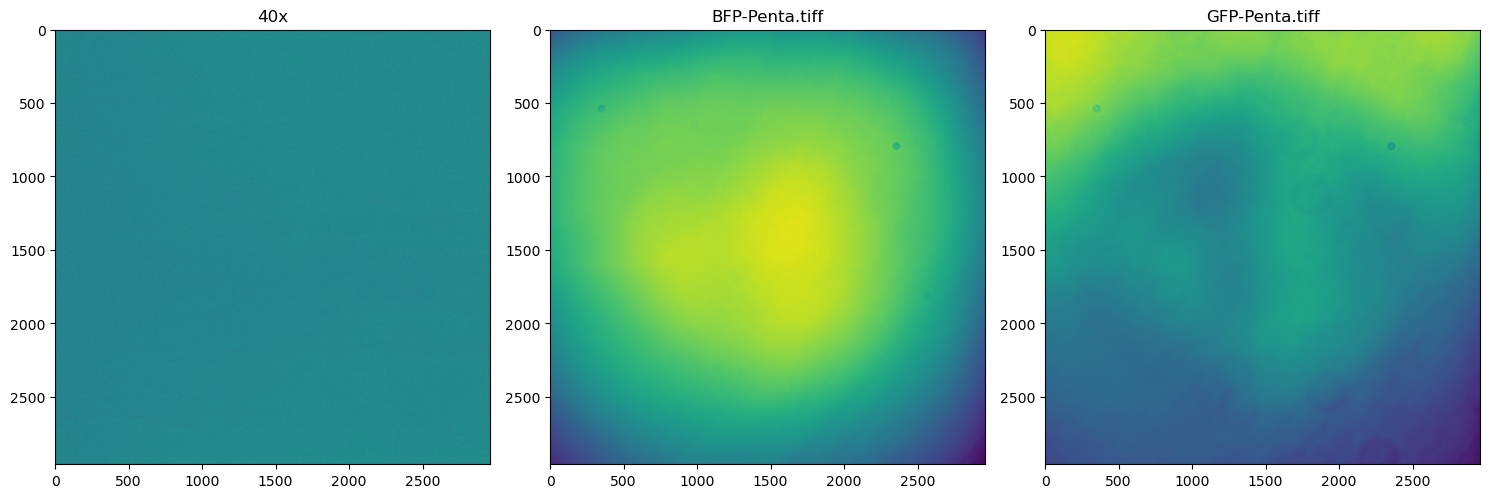

In [6]:
dark_outputpath = "/home/de64/scratch/de64/sync_folder/2022-12-26_Flat_Fields_Iris_9_40x/40x_DarkImage.tiff"
BFP_outputpath = "/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/BFP-Penta.tiff"
GFP_outputpath = "/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/GFP-Penta.tiff"

fflist = [dark_outputpath,BFP_outputpath,GFP_outputpath]

fig, axs = plt.subplots(figsize=(15, 20), nrows= 1, ncols = 3)

for i in range(3):
    axs[i].imshow(tifffile.imread(fflist[i]))
    axs[i].set_title(fflist[i].split('/')[-1].split('_')[0])
plt.tight_layout()

### Convert Nd2 Files to tiff

In [9]:
# convert nd2 files to tiff (custom) of format t{timepoints:d}xy{fov:d}c{channel:d}.tif
# record mapping from condition to fov range in secondary dataframe

nd2_path = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds"
tiff_output_path = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds/tiff"

tr.writedir(tiff_output_path, overwrite=True)

nd2_files = []
for root, _, files in os.walk(nd2_path):
    nd2_files.extend([os.path.join(root, f) for f in files if ".nd2" in os.path.splitext(f)[1]])


ndmeta_handle = tr.nd_metadata_handler(nd2_files[0],ignore_fovmetadata=False)
exp_metadata,fov_metadata = ndmeta_handle.get_metadata()
tiff_metadata = [(65326,'d',1,exp_metadata['pixel_microns'],True)]
channels = exp_metadata["channels"]

parsestr = "DE{Strain:d}_{IPTG_Concentration:d}uM_R{Run:d}.nd2"
parser = compile(parsestr)

running_fov_idx = 0

all_fov_metadata = []
dask_futures = {}
for nd2_i,nd2_file in enumerate(nd2_files):
    ndmeta_handle = tr.nd_metadata_handler(nd2_file,ignore_fovmetadata=False)
    exp_metadata,fov_metadata = ndmeta_handle.get_metadata()
    new_fov_series = fov_metadata.reset_index()["fov"] + running_fov_idx
    fov_metadata = fov_metadata.reset_index()
    fov_metadata = fov_metadata.rename(columns={"fov": "old fov"})
    fov_metadata["fov"] = new_fov_series
    fov_metadata = fov_metadata.set_index(["fov","timepoints"])
    
    for i,channel in enumerate(exp_metadata['channels']):
        file_name_series = fov_metadata.reset_index().apply(lambda x: "t" + str(int(x["timepoints"])) + "xy" + str(int(x["fov"])) + "c" + str(i) + ".tif", axis=1)
        file_name_series.index = fov_metadata.index
        fov_metadata[channel + " File Names"] = file_name_series

    match = parser.search(nd2_file)
    # Add to dictionary
    parser_dict = match.named
    for key, value in parser_dict.items():
        fov_metadata[key] = value

    all_fov_metadata.append(fov_metadata)
    running_fov_idx += len(fov_metadata)

    dask_controller.futures["nd2 Convert: " + str(nd2_i)] = dask_controller.daskclient.submit(nd2_to_tiff,nd2_file,fov_metadata,channels,tiff_metadata)
all_fov_metadata = pd.concat(all_fov_metadata)
dask_controller.daskclient.gather([future for key,future in dask_controller.futures.items() if "nd2 Convert" in key]);
all_fov_metadata.to_pickle(tiff_output_path + "/conversion_metadata.pkl")

AttributeError: 'NoneType' object has no attribute 'named'

### Tiff Extraction

In [47]:
# dark_outputpath = "/home/de64/scratch/de64/sync_folder/2022-12-26_Flat_Fields_Iris_9_40x/40x_DarkImage.tiff"
# BFP_outputpath = "/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/BFP-Penta.tiff"
# GFP_outputpath = "/home/de64/scratch/de64/sync_folder/2023-09-10_Flat_Fields_Iris_9_100x_MRD31905/GFP-Penta.tiff"

In [48]:
headpath = '/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds'
tiff_output_path = '/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds/tiff'
channels = ["GFP-Penta","BFP-Penta","MicroManager-Phase"]

tiff_extractor = tr.tiff_extractor(tiff_output_path,headpath,channels)

In [49]:
tiff_extractor.inter_set_params()

/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:86: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_paths'], dtype='object')]

  store.put(key, df)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


interactive(children=(SelectMultiple(description='fov_list', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

In [51]:
tiff_extractor.inter_set_flatfieldpaths()

In [52]:
tiff_extractor.extract(dask_controller)

/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is a Python keyword: 'global'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:86: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_paths'], dtype='object')]

  store.put(key, df)
/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/t

### Phase Segmentation (Omnipose)

In [7]:
dask_controller = tr.trcluster.dask_controller(
    walltime="2:00:00",
    local=False,
    n_workers=10,
    n_workers_min=10,
    queue='gpu_quad',
    memory="8GB",
    working_directory=dask_wd,
    job_extra_directives=["--gres", "gpu:teslaV100s:1"]

)
dask_controller.startdask()

110m
2:00:00


In [8]:
dask_controller.displaydashboard()

In [10]:
headpath = '/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds'
seg_channel = "MicroManager-Phase"
overwrite = True

tr.writedir(headpath + "/phasesegmentation", overwrite=overwrite)
meta_handle = tr.pandas_hdf5_handler(headpath + "/metadata.hdf5")
file_idx_list = np.unique(meta_handle.read_df("global")["File Index"])

for file_idx in file_idx_list:
    dask_controller.futures["Omnipose: " + str(file_idx)] = dask_controller.daskclient.submit(segment_omnipose,headpath,file_idx,seg_channel)
dask_controller.daskclient.gather([future for key,future in dask_controller.futures.items() if "Omnipose" in key]);

### Nucleoid Segmentation (Cell-wise Otsu)

In [17]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=20,
    n_workers_min=20,
    queue='short',
    memory="8GB",
    working_directory=dask_wd,
    job_extra_directives=[]

)
dask_controller.startdask()

50m
1:00:00


In [18]:
dask_controller.displaydashboard()

In [43]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds"
cell_otsu_scaling = 1.
seg_channel = "BFP-Penta"
nucleoidsegfolder = "nucleoidsegmentation"
cellsegfolder = "phasesegmentation"
overwrite = True

tr.writedir(headpath + "/" + nucleoidsegfolder, overwrite=overwrite)
meta_handle = tr.pandas_hdf5_handler(headpath + "/metadata.hdf5")
file_idx_list = np.unique(meta_handle.read_df("global")["File Index"])

for file_idx in file_idx_list:
    dask_controller.futures["Nucleoid: " + str(file_idx)] = dask_controller.daskclient.submit(segment_nucleoids,file_idx,headpath,cellsegfolder,nucleoidsegfolder,seg_channel,cell_otsu_scaling)
dask_controller.daskclient.gather([future for key,future in dask_controller.futures.items() if "Nucleoid" in key]);

### Regionprops Parallelizer

In [328]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds"

cell_analyzer = regionprops_extractor_agarpad(
    headpath,
    "phasesegmentation",
    "cell_analysis",
    intensity_channel_list=['GFP-Penta', 'BFP-Penta'],
    props_list=["centroid","area","major_axis_length","minor_axis_length"],
    pixel_scaling_factors={'area': 2, 'centroid_y': 1, 'centroid_x': 1, 'major_axis_length': 1, 'minor_axis_length': 1},
)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [329]:
cell_analyzer.analyze_all_files(dask_controller)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/dask/dataframe/core.py:5252: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/dask/dataframe/core.py:6002: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(me

In [45]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds"

nuc_analyzer = regionprops_extractor_agarpad(
    headpath,
    "nucleoidsegmentation",
    "nuc_analysis",
    intensity_channel_list=['BFP-Penta'],
)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [46]:
nuc_analyzer.analyze_all_files(dask_controller)

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/dask/dataframe/core.py:5252: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/home/de64/micromamba/envs/agarpad/lib/python3.10/site-packages/dask/dataframe/core.py:6002: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(me

### Assign Nucleoids to Cells

In [4]:
dask_controller = tr.trcluster.dask_controller(
    walltime="1:00:00",
    local=False,
    n_workers=10,
    n_workers_min=10,
    queue='short',
    memory="8GB",
    working_directory=dask_wd,
    job_extra_directives=[]

)
dask_controller.startdask()

50m
1:00:00


In [29]:
## assign cellids to the nucleoid df

In [7]:
headpath = "/home/de64/scratch/de64/sync_folder/2023-10-01_DNA_RNA_Strain_All_Rounds"

cell_df = dd.read_parquet(headpath + "/cell_analysis",calculate_divisions=True).compute()
cell_df = cell_df[cell_df["Objectid"] != 0]

nuc_df = dd.read_parquet(headpath + "/nuc_analysis",calculate_divisions=True)
nuc_df = nuc_df[nuc_df["Objectid"] != 0]
nuc_df = nuc_df.repartition(npartitions=20)
pixel_microns = tr.pandas_hdf5_handler(headpath + "/metadata.hdf5").read_df("global",read_metadata=True).metadata['pixel_microns']
nuc_df = nuc_df.groupby("fov").apply(lambda x: nucleoid_cellid(x,pixel_microns)).compute().droplevel(0).sort_index()

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:93: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata
/tmp/ipykernel_9555/3656493055.py:10: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  nuc_df = nuc_df.groupby("fov").apply(lambda x: nucleoid_cellid(x,pixel_microns)).compute().droplevel(0).sort_index()


In [8]:
### filter parameters
GFP_intensity_thr = 1300
BFP_intensity_thr = 3500
area_thr = 0.8

total_nucleoid_area_df = nuc_df.groupby(["fov","timepoints","Cell Objectid"])["area"].sum().to_frame()
mean_intensity_df = nuc_df.groupby(["fov","timepoints","Cell Objectid"])["BFP-Penta mean_intensity"].mean().to_frame()
total_intensity_df = nuc_df.groupby(["fov","timepoints","Cell Objectid"]).apply(lambda x: np.sum(x["area"]*x["BFP-Penta mean_intensity"])).to_frame()
nucleoid_cell_df = pd.concat([total_nucleoid_area_df,mean_intensity_df,total_intensity_df], axis=1)
nucleoid_cell_df = nucleoid_cell_df.rename(columns={"area":"Total Nucleoid Area","BFP-Penta mean_intensity":"Avg Nucleoid mean_intensity",0:"Total Nucleoid Intensity"})
nuc_df_fov_idx = nucleoid_cell_df.reset_index().apply(lambda x: int(f'{x["fov"]:08n}{x["timepoints"]:04n}{x["Cell Objectid"]:02n}'), axis=1)
nucleoid_cell_df = nucleoid_cell_df.reset_index()
nucleoid_cell_df["FOV Parquet Index"] = nuc_df_fov_idx
nucleoid_cell_df = nucleoid_cell_df.drop(["fov","timepoints","Cell Objectid"], axis=1)
nucleoid_cell_df = nucleoid_cell_df.set_index("FOV Parquet Index")
cell_df_fov_idx = cell_df.apply(lambda x: int(f'{x["fov"]:08n}{x["timepoints"]:04n}{x["Objectid"]:02n}'), axis=1)
cell_df["FOV Parquet Index"] = cell_df_fov_idx
cell_df_with_nucleoid = cell_df.set_index("FOV Parquet Index")
cell_df_with_nucleoid = cell_df_with_nucleoid.join(nucleoid_cell_df)

## extra filters for true cells
cell_df_with_nucleoid = cell_df_with_nucleoid[(cell_df_with_nucleoid["GFP-Penta mean_intensity"]>GFP_intensity_thr)&\
                                              (cell_df_with_nucleoid["BFP-Penta mean_intensity"]>BFP_intensity_thr)]

cell_df_with_nucleoid["Nucleoid Area Ratio"] = cell_df_with_nucleoid["Total Nucleoid Area"]/cell_df_with_nucleoid["area"]

conversion_metadata_df = pd.read_pickle(headpath + '/tiff/conversion_metadata.pkl').reset_index()[["fov","Strain","IPTG_Concentration","Run"]].set_index("fov")
cell_df_with_nucleoid = cell_df_with_nucleoid.join(conversion_metadata_df,on="fov")

cell_df_with_nucleoid = cell_df_with_nucleoid[cell_df_with_nucleoid["area"]>area_thr]
cell_df_with_nucleoid.to_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/Imaging/Final_Output_df.pkl")
cell_df_with_nucleoid.to_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/Imaging/Final_Output_df.csv")